In [32]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, r2_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder


In [33]:
df = pd.read_csv(r'C:\Users\DAI.STUDENTSDC\Desktop\Machine Learning\Data Sets\Cases\Medical Cost Personal\insurance.csv')
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [34]:
X = df.drop(columns=['charges'], axis=1)
y = df['charges']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

GridSearchCV

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 936 entries, 476 to 418
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       936 non-null    int64  
 1   sex       936 non-null    object 
 2   bmi       936 non-null    float64
 3   children  936 non-null    int64  
 4   smoker    936 non-null    object 
 5   region    936 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 51.2+ KB


In [37]:
ohe = OneHotEncoder(
    sparse_output=False, 
    drop='first'
).set_output(transform='pandas')


ct =make_column_transformer(
    ('passthrough', make_column_selector(dtype_exclude=[
        'object',
        'category',
    ])),
    (ohe, make_column_selector(dtype_include=[
        'object',
        'category',
    ])),
    verbose_feature_names_out=False,
).set_output(transform='pandas')



In [70]:
dtr = DecisionTreeRegressor(random_state=24)

pipe = Pipeline([
    ('ct', ct),
    ('DT', dtr),
])

params = { 
    'DT__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'DT__max_depth': list([None, 2, 3, 4, 5, 6]), #list([3, 4, 5, 6])
    'DT__min_samples_leaf' :  np.linspace(1, 50, 7).astype(int),
    'DT__min_samples_split':  np.linspace(2, 50, 5).astype(int),
}

kfold = KFold(n_splits=5, shuffle=True, random_state=24)


gcvr = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=kfold,
    scoring='r2',
    verbose=2,
)



In [71]:
gcvr.fit(X_train, y_train)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
[CV] END DT__criterion=squared_error, DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2; total time=   0.0s
[CV] END DT__criterion=squared_error, DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2; total time=   0.0s
[CV] END DT__criterion=squared_error, DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2; total time=   0.0s
[CV] END DT__criterion=squared_error, DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2; total time=   0.0s
[CV] END DT__criterion=squared_error, DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2; total time=   0.0s
[CV] END DT__criterion=squared_error, DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=14; total time=   0.0s
[CV] END DT__criterion=squared_error, DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=14; total time=   0.0s
[CV] END DT__criterion=squared_error, DT__max_depth=

GridSearchCV(cv=KFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000107F335CF80>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_c...t at 0x00000107F335D610>)],
                                                          verbose_feature_names_out=False)),
                                       ('DT',
                                        DecisionTreeRegressor(random_state=24))]),
             param_grid={'DT__criterion': ['squared_error', 'friedman_mse',
                                           'absolute_error', 'poisson'],
                         'DT__max_depth': [None, 2, 3, 4, 5, 6],
                         'DT__min_samples_leaf': array([ 1,  9, 17, 25, 33, 41, 50]),
                         'DT__min_samples_split': array([ 2, 14, 26, 38, 50])},
             scoring='r2', verbose=2)

In [72]:
print('Best score: ', gcvr.best_score_)
print('Best parameters: ', gcvr.best_params_)

Best score:  0.836542876155393
Best parameters:  {'DT__criterion': 'poisson', 'DT__max_depth': 4, 'DT__min_samples_leaf': 17, 'DT__min_samples_split': 2}


In [41]:
best_dtr = gcvr.best_estimator_.named_steps['DT']
y_pred = gcvr.best_estimator_.predict(X_test) 

print(r2_score(y_test, y_pred)) 


0.8739742865125164


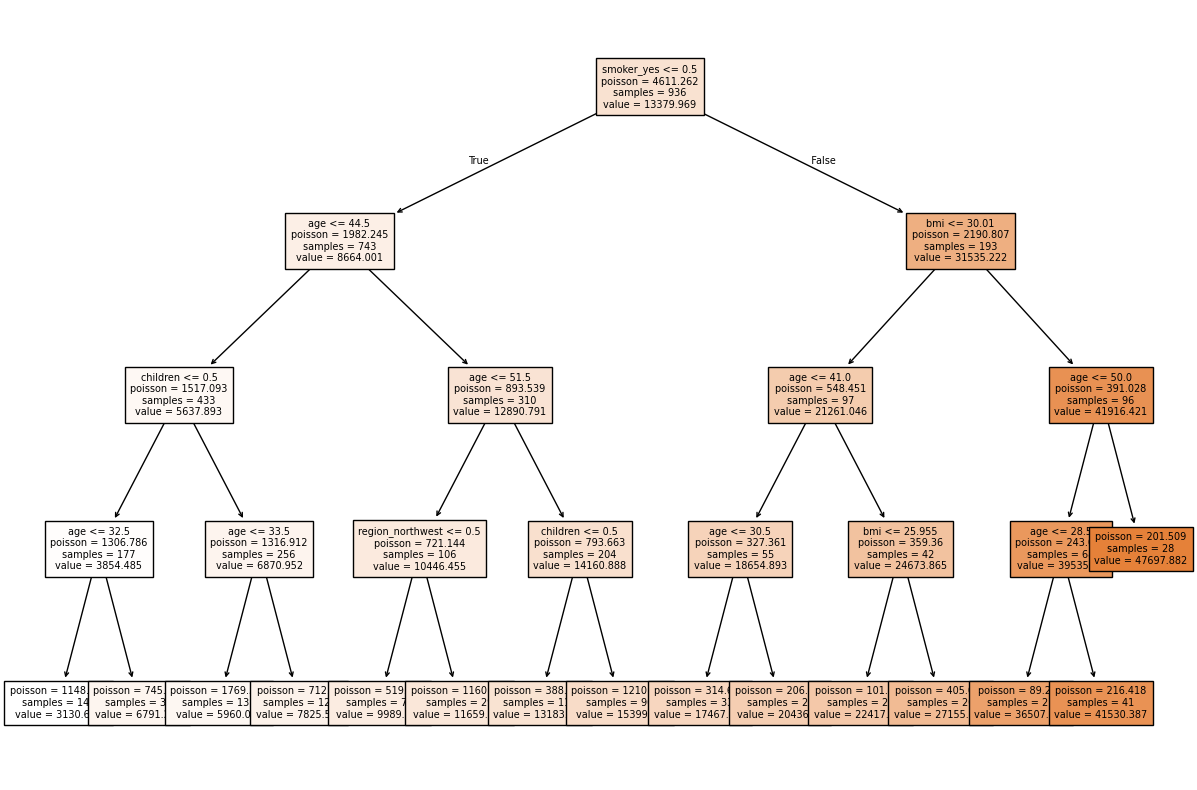

In [74]:
feature_names = list(gcvr.best_estimator_.named_steps['ct'].get_feature_names_out())

plt.figure(figsize=(15, 10))
plot_tree(best_dtr, feature_names=feature_names, filled=True, fontsize=7)
plt.show()



In [43]:
# The total number of edges from the root node to the leaf node in the longest path is known as "Depth of Tree".
tree_depth = best_dtr.get_depth()
print("tree_depth: ", tree_depth)

tree_depth:  4


In [44]:
df_imp = pd.DataFrame({
    'features': feature_names,
    'importance': best_dtr.feature_importances_
})


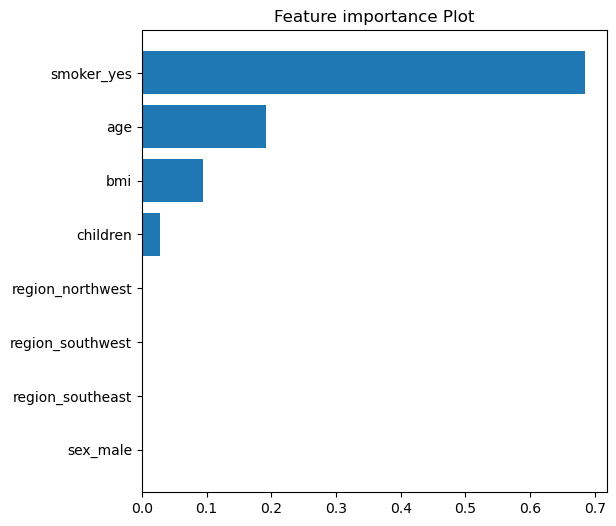

In [45]:
df_imp.sort_values('importance', inplace=True)

plt.figure(figsize=(6, 6))
plt.barh(df_imp['features'], df_imp['importance'])
plt.title('Feature importance Plot')
plt.show()

In [ ]:
# Testing with no "depth" parameter, to get tree with max depth

# dtr = DecisionTreeRegressor(random_state=24) #This is the same as the previous one

# pipe = Pipeline([
#     ('ct', ct),
#     ('DT', dtr),
# ])

params = { 
    'DT__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
}

kfold = KFold(n_splits=5, shuffle=True, random_state=24)

gcvr1 = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=kfold,
    scoring='r2',
    verbose=1,
)



In [57]:
gcvr1.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000107F335CF80>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000107F335D610>)],
                                                          verbose_feature_names_out=False)),
                                       ('DT',
                                        DecisionTreeRegressor(random_state=24))]),
             param_grid={'DT__criterion': ['squared_error', 'friedman_mse',
                                           'absolute_error', 'poisson']},
             scoring='r2', verbose=1)

In [75]:
print('Best score: ', gcvr1.best_score_)
print('Best parameters: ', gcvr1.best_params_)

Best score:  0.6853463008235238
Best parameters:  {'DT__criterion': 'poisson'}


In [59]:
best_tree = gcvr1.best_estimator_.named_steps['DT']
tree_depth = best_tree.get_depth()
print("tree_depth: ", tree_depth)

tree_depth:  17


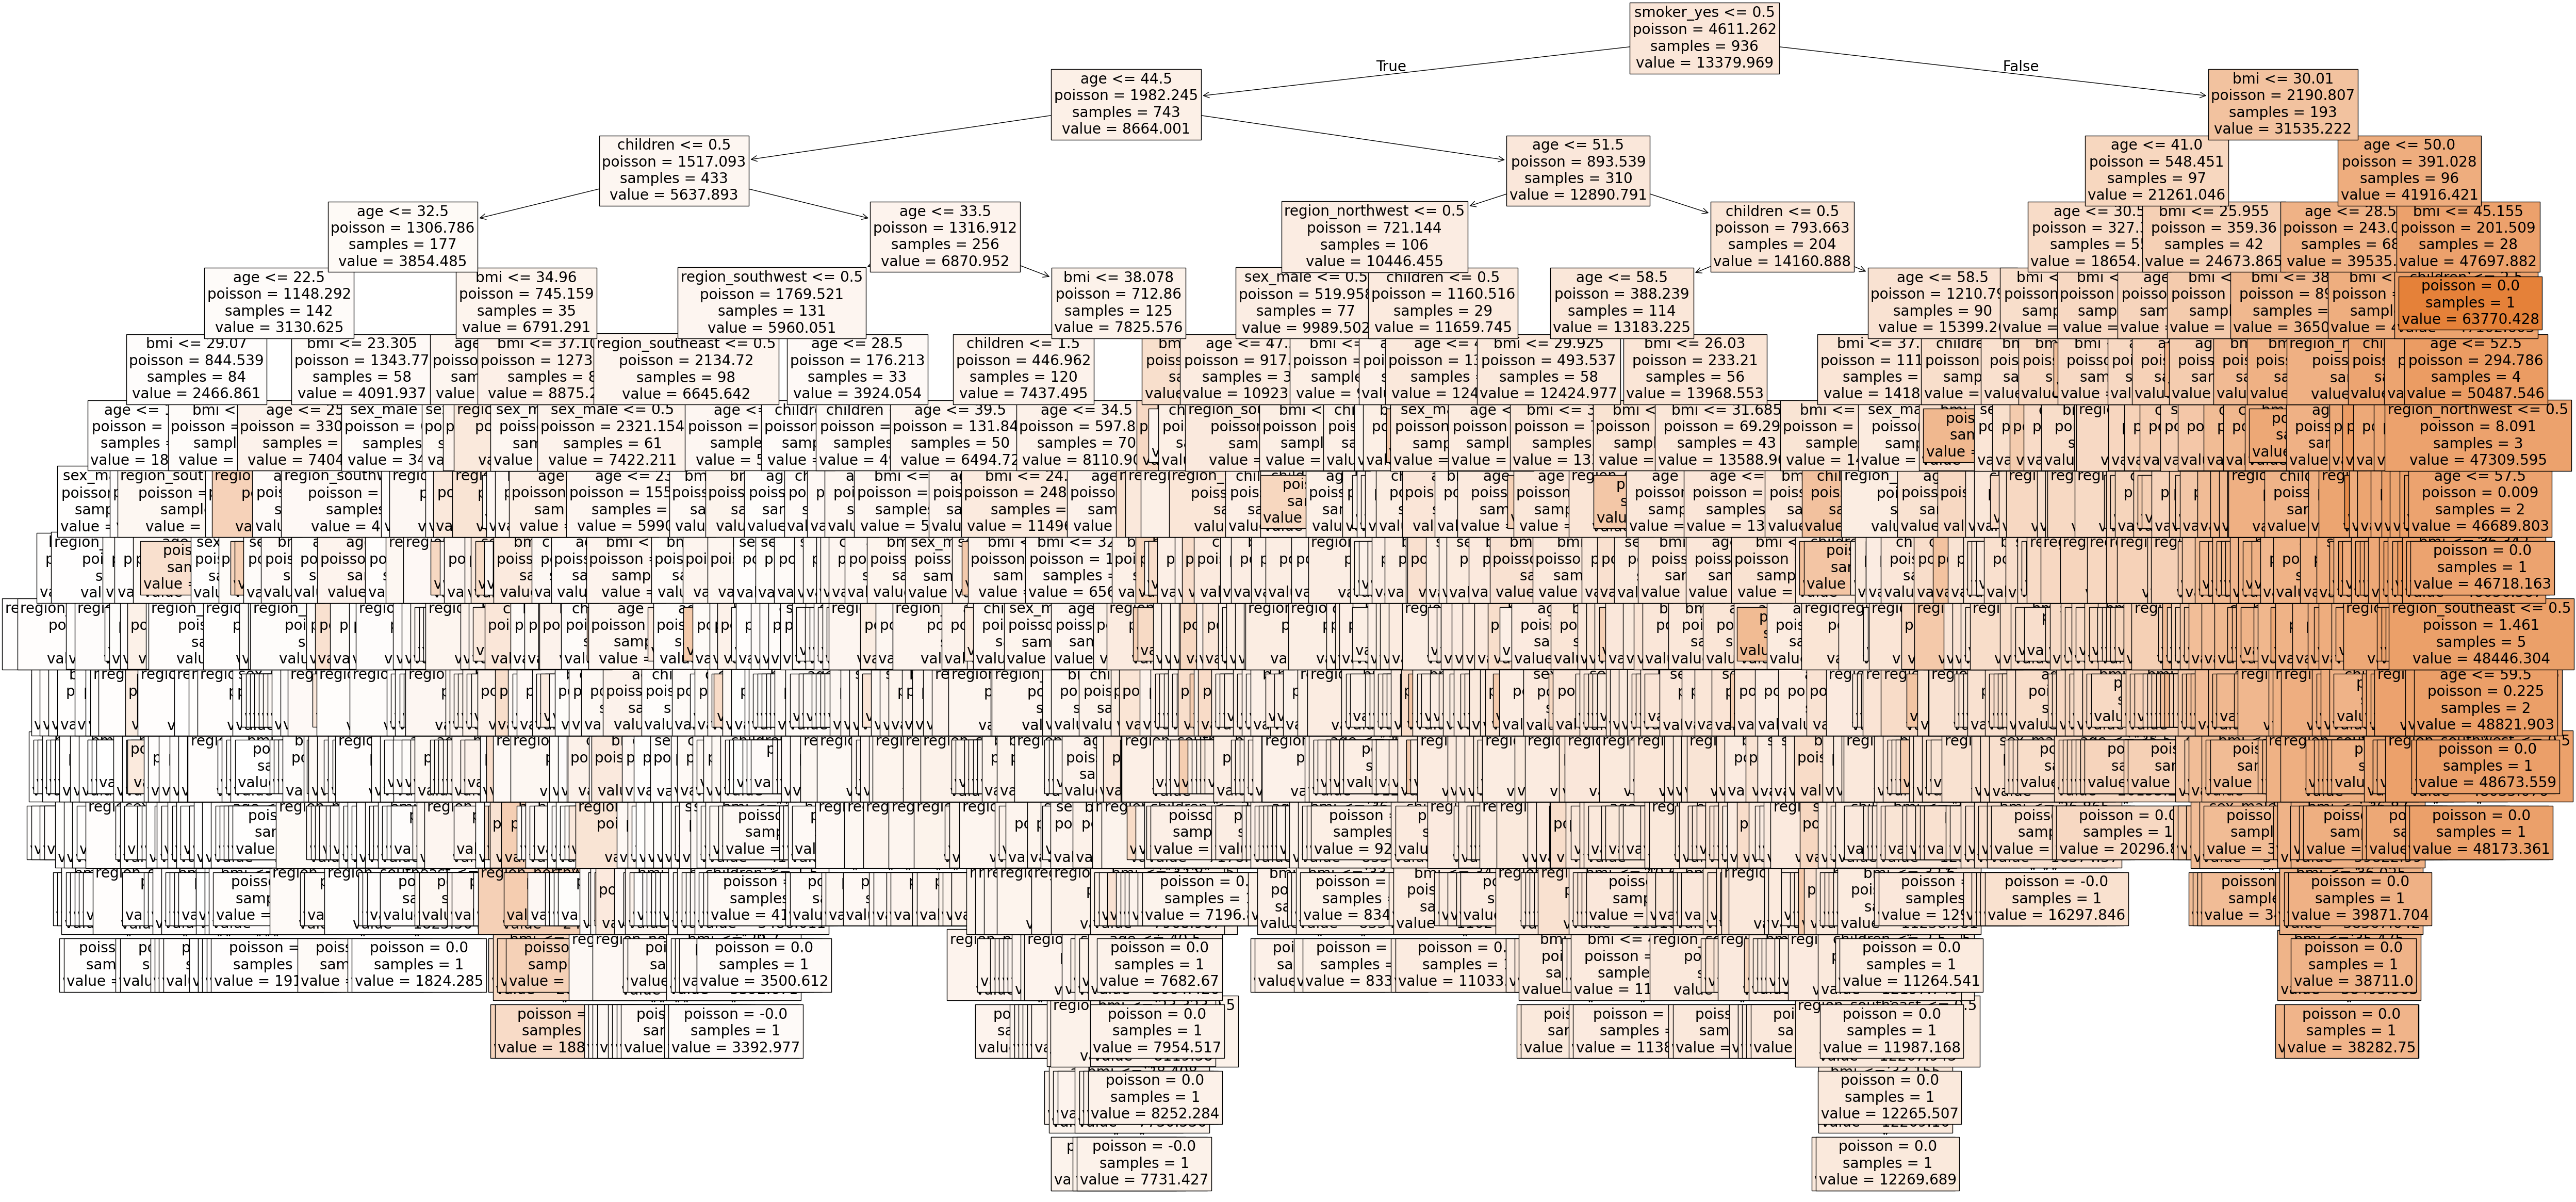

In [60]:
feature_names = list(gcvr.best_estimator_.named_steps['ct'].get_feature_names_out())

plt.figure(figsize=(60, 30))
plot_tree(best_tree, feature_names=feature_names, filled=True, fontsize=20)
plt.show()



In [ ]:
# Testing with 'depth' parameter, and with no 'min_samples_leaf' ,'min_samples_split'

# dtr = DecisionTreeRegressor(random_state=24) #This is the same as the previous one

# pipe = Pipeline([
#     ('ct', ct),
#     ('DT', dtr),
# ])

params = { 
    'DT__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'DT__max_depth': np.linspace(1, tree_depth, tree_depth).astype(int),
}

kfold = KFold(n_splits=5, shuffle=True, random_state=24)

gcvr2 = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=kfold,
    scoring='r2',
    verbose=1,
)

gcvr2.fit(X_train, y_train)

Fitting 5 folds for each of 68 candidates, totalling 340 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000107F335CF80>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000107F335D610>)],
                                                          verbose_feature_names_out=False)),
                                       ('DT',
                                        DecisionTreeRegressor(random_state=24))]),
             param_grid={'DT__criterion': ['squared_error', 'friedman_mse',
                                           'absolute_error', 'poisson'],
                         'DT__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])},
             scoring='r2', verbose=1)

In [64]:
print('Best score: ', gcvr2.best_score_)
print('Best parameters: ', gcvr2.best_params_)

Best score:  0.8306103715237058
Best parameters:  {'DT__criterion': 'absolute_error', 'DT__max_depth': 4}


In [65]:
best_tree = gcvr2.best_estimator_.named_steps['DT']
tree_depth = best_tree.get_depth()
print("tree_depth: ", tree_depth)

tree_depth:  4


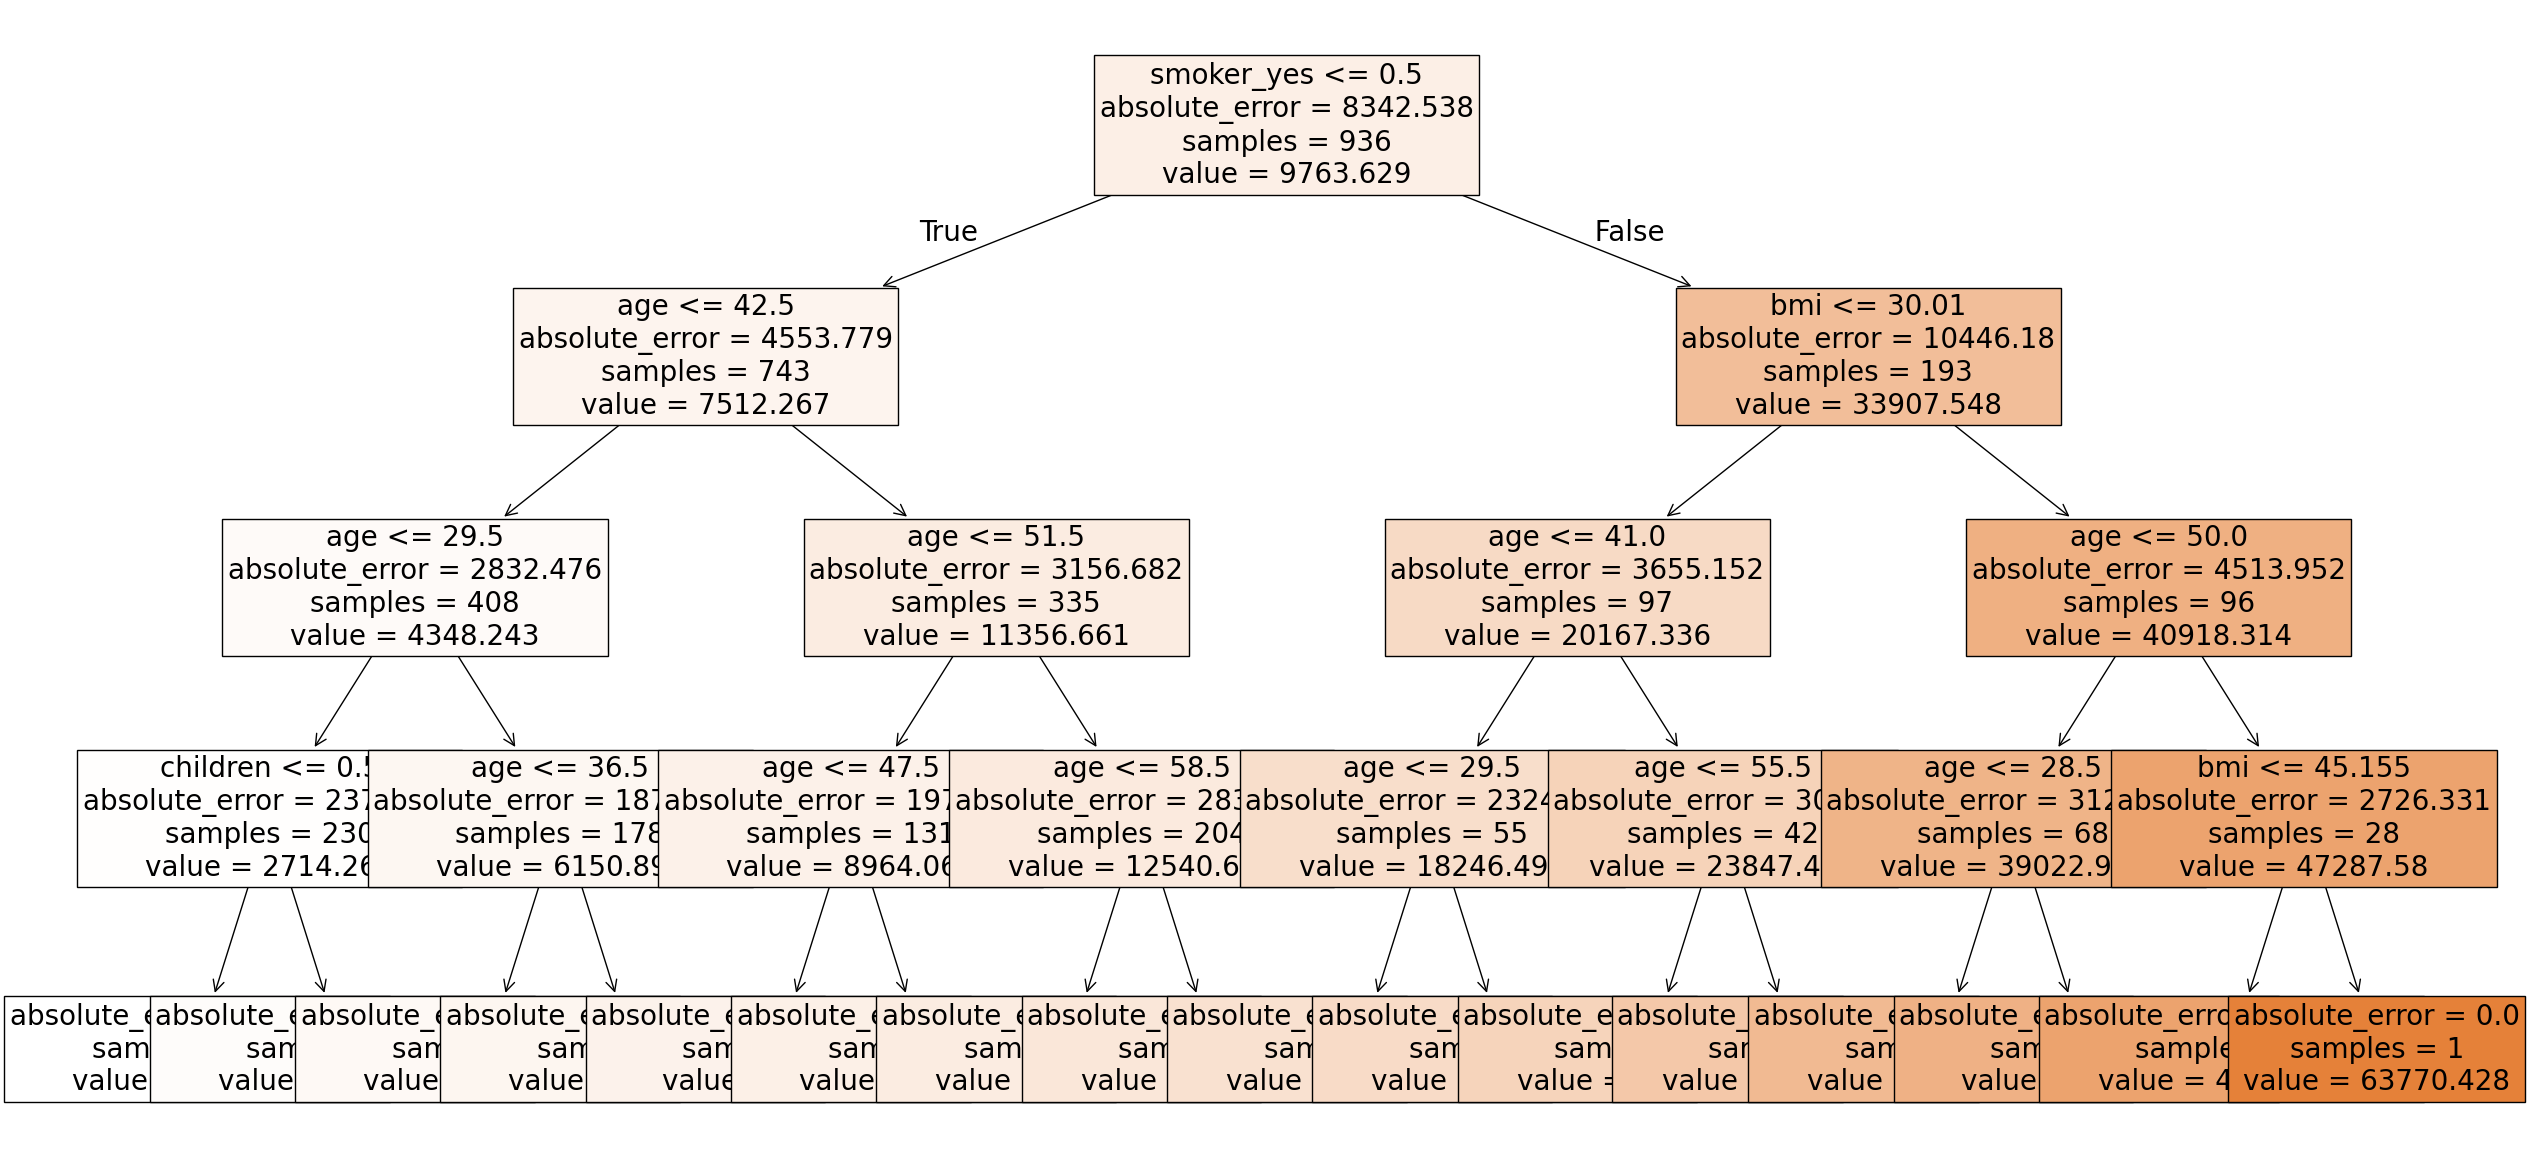

In [68]:
feature_names = list(gcvr2.best_estimator_.named_steps['ct'].get_feature_names_out())

plt.figure(figsize=(30, 15))
plot_tree(best_tree, feature_names=feature_names, filled=True, fontsize=20)
plt.show()